UNIVERSIDAD GALILEO

Stadistical-learning

Marco Vinicio Escalante Lara

Carnet: 19001148

# Regresion Polinomial & Feature engineering

In [5]:
import pandas as pd

In [6]:
data = pd.read_csv('winequality-red.csv')

### Red Wine Quality Data

Se aplicará regresión para crear un modelo de la calidad de vino en función de características del mismo, siendo 1 el peor vino y 10 el mejor.

Variables de entrada:
1. fixed acidity 
2. volatile acidity 
3. citric acid 
4. residual sugar 
5. chlorides 
6. free sulfur dioxide 
7. total sulfur dioxide 
8. density 
9. pH 
10. sulphates 
11. alcohol 

Varaible a predecir: 
12. quality (puntuacion  entre 0 y 10) 



In [3]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### Instrucciones

1. Seleccionar y transformar(generando las combinaciones polinomiales para un polinomio de grado dos o tres a elección) las features que considere que son las mejores para predecir la calidad del vino, utilizar como minimo 2 features. Para seleccionar las features, hacer un analisis exploratorio por ejemplo(pero no limitado a ):  graficando y viendo la forma en que se comportan los datos.

 Por ejemplo, se tienen las features "a" y "b" y seleccionamos polinomio de grado 2, hacemos feature engineering para obtener :
 
 $[a,b,a^{2},b^{2},ab]$
 
 No olvidar el "bias" (parámetro multiplicado por 1) ,con lo cual el dataset puede quedar con las columnas:
 
 $[1,a,b,a^{2},b^{2},ab]$
2. Una vez transformada la data aplicar regresion lineal con las features polinomiales usando Tensorflow.

Requisitos adicionales:
* Se debe agregar al notebook un screenshot del grafo de tensorboard, simplificando(usando  names , y name_scope como visto en clase).

* Se debe generar un directorio de logs de tensorboard para cada corrida/experimento , con cada directorio identificando facilmente la configuración del experimento como visto en clase, por ejemplo para un experimento con learning rate = 0.1 , y polinomio grado 2  crear un directorio: lr=0.1_polinomio_grado=2. (Agregar al notebook un screenshot de estas gráficas)

* Concluir en markdown cual es el mejor modelo para este caso basado en la comparativa entre curvas de costo/error en tensorboard.

In [28]:
import numpy as np
import tensorflow as tf 
import seaborn as sns
import matplotlib.pyplot as plt

# Selección de variables para modelo

Histogramas de las variables

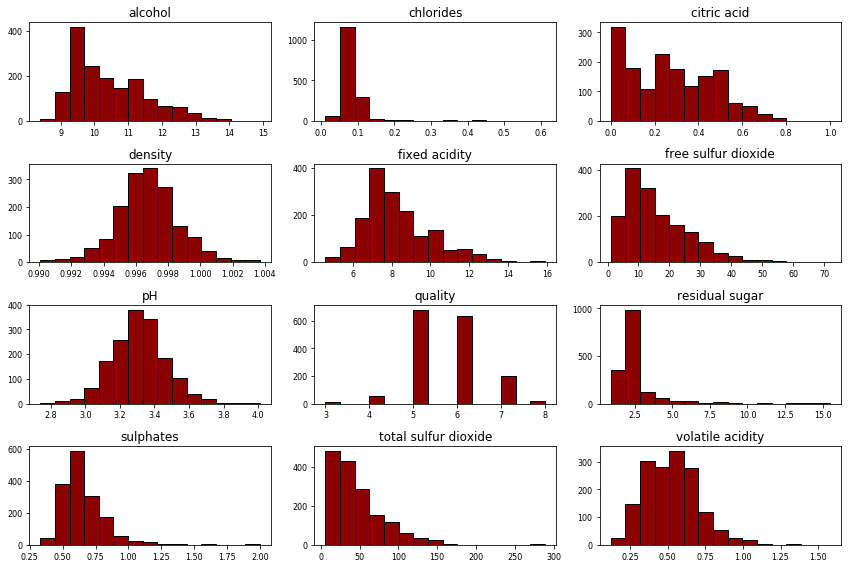

In [46]:
data.hist(bins=15, color='darkred', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)    
plt.tight_layout(rect=(0, 0, 2, 2))   

# Matriz de Correlación montada sobre un mapa de calor

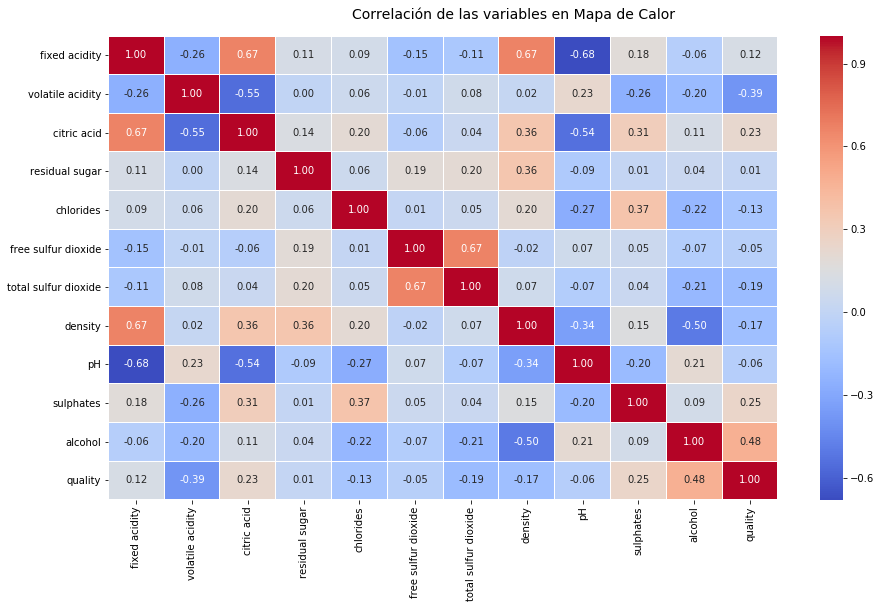

In [50]:
f, ax = plt.subplots(figsize=(15, 8))
corr = data.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Correlación de las variables en Mapa de Calor', fontsize=14)

# Graficar variables con mayor correlación

Se seleccionaron las variables 'Volatile acidity' y 'alcohol' ya que tenian mayor relevancia para calidad.

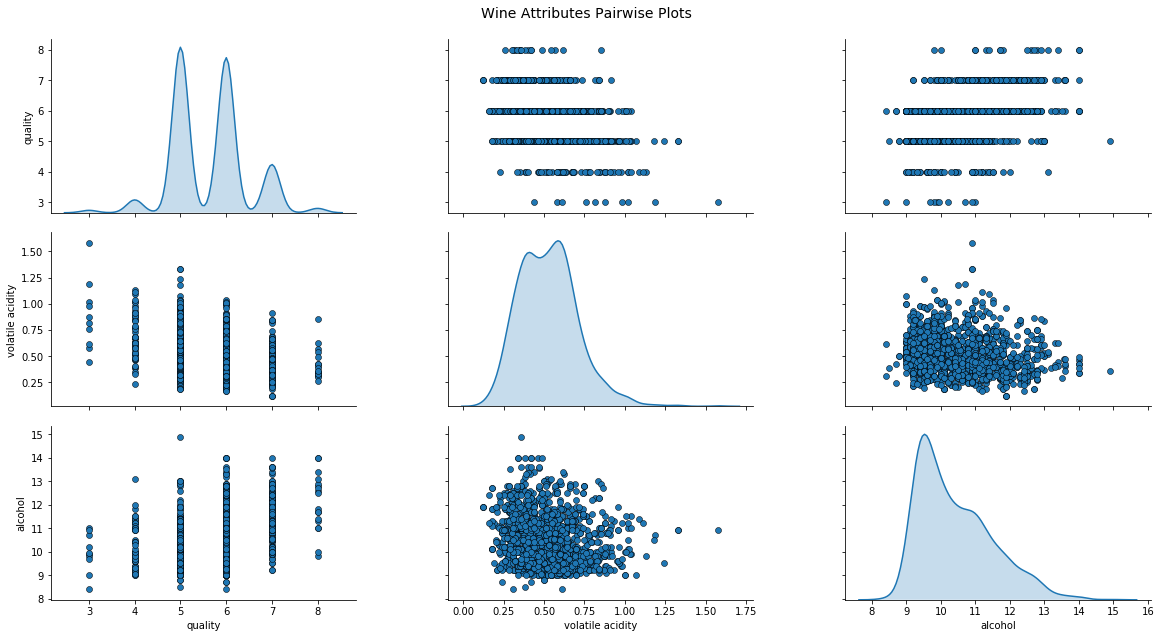

In [62]:
variables = ['quality', 'volatile acidity', 'alcohol']
pp = sns.pairplot(data[variables], height=3, aspect=1.8,
                  plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kind="kde", diag_kws=dict(shade=True))

fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Variables', fontsize=14)

Utilizando las variables "Volatile acidity" y "Alcohol" para hacer nuestra regresión polinomial ya que estas variables presentan mayor correlación con la calidad se procede a trabajar:

Por los datos tomados se trabajara con las variables propuestas.

In [73]:
x1=data['alcohol']
x2=data['alcohol']*data['alcohol']
x3=data['volatile acidity']
x4=data['volatile acidity']*data['volatile acidity']
x5=data['alcohol']*data['volatile acidity']
y1=data['quality']

var_x = np.array([x1, x2, x3, x4, x5]).transpose()
var_y = np.array([y1]).transpose()
n = var_x.shape[0]

# Definición de Grafo


In [75]:
tf.reset_default_graph()

#Generando nuestro grafo
gra = tf.Graph()
with gra.as_default(): 
    X = tf.placeholder(tf.float32, shape= (None, 5), name="X") 
    Y = tf.placeholder(tf.float32, shape = (None, 1), name = "Y")
    learning_rate = tf.placeholder(tf.float32, name="Learning_Rate") 
    
    W = tf.Variable(tf.zeros([5,1], tf.float32), name="W") 
    b = tf.Variable(0, name = "b", dtype="float") 
    
    # Hipotesis a comprobar
    
    with tf.name_scope("hipotesis"):
        y_pred = tf.add(tf.matmul(X, W, name ="hipotesis_producto_punto"), b, name="hipotesis_sumar_b")
        
    with tf.name_scope("cost"):
        cost = tf.reduce_sum(tf.pow(y_pred-Y, 2)) / (2 * n)
        
    # Optiminzador del Gradiente
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost) 
      
    # Inicializar variables globales
    init = tf.global_variables_initializer() 

    # Donde guardaremos la información de la función
    testSummary = tf.summary.scalar(name='Funcion_de_costo', tensor = cost)
    
def regresion_tf(x, y, epochs, learning_r):
    # Iniciando sesión de TF 
    tf.reset_default_graph() 
    with tf.Session(graph=gra) as sess: 
      
        writer = tf.summary.FileWriter('./regresion_pol/lr='+str(learning_r), sess.graph)    
        # Inicializando las variables 
        sess.run(init) 
      
        # Iterando a traves de los epochs
        for epoch in range(epochs): 
           
            _ = sess.run(optimizer, feed_dict = {X : x, Y : y, learning_rate : learning_r}) 
          
            # DMostrar los valores cada vez que sea un numero divisible entre 50 
            if (epoch + 1) % 50 == 0: 
                # Calculando la función de costo en cada epoch calculado 
                c = sess.run(cost, feed_dict = {X : x, Y : y}) 
                print("Epoch", (epoch + 1), ": cost =", c, "W =", sess.run(W), "b =", sess.run(b)) 
          
            # Ejecutar el summary 
            summary = sess.run(testSummary, feed_dict = {X : x, Y : y})
            # Agregarlo al tablero de Tensorbord
            writer.add_summary(summary, epoch)
            
        training_cost = sess.run(cost, feed_dict ={X: x, Y: y}) 
        weight = sess.run(W) 
        bias = sess.run(b) 
        
        writer.close()

# Ejemplo de regresión 

In [71]:
regresion_tf(var_x, var_y, 400, 0.000001)

Epoch 50 : cost = 4.9079833 W = [[2.2092750e-03]
 [2.3318222e-02]
 [1.0933885e-04]
 [6.2982057e-05]
 [1.1335555e-03]] b = 0.00021150454
Epoch 100 : cost = 1.7692089 W = [[3.3942203e-03]
 [3.5605252e-02]
 [1.6861199e-04]
 [9.6769501e-05]
 [1.7383643e-03]] b = 0.00032679574
Epoch 150 : cost = 0.8973555 W = [[0.00403931]
 [0.04207856]
 [0.0002015 ]
 [0.00011517]
 [0.00206451]] b = 0.00039137952
Epoch 200 : cost = 0.65515924 W = [[0.00439989]
 [0.04548785]
 [0.00022048]
 [0.00012546]
 [0.00224378]] b = 0.0004292387
Epoch 250 : cost = 0.58785444 W = [[0.00461052]
 [0.04728235]
 [0.00023213]
 [0.00013148]
 [0.00234565]] b = 0.00045301308
Epoch 300 : cost = 0.5691278 W = [[0.00474211]
 [0.04822579]
 [0.00023992]
 [0.00013524]
 [0.00240672]] b = 0.00046936393
Epoch 350 : cost = 0.56389385 W = [[0.00483205]
 [0.0487207 ]
 [0.00024567]
 [0.00013782]
 [0.00244628]] b = 0.00048180204
Epoch 400 : cost = 0.56240785 W = [[0.00490003]
 [0.04897922]
 [0.00025035]
 [0.00013977]
 [0.00247451]] b = 0.0004

# Grafo de Tensorbord

<img src="Grafo.png">

# Directorio de logs de tensorboard para cada corrida/experimento 

<img src="LR.png">

# Conclusiones:

1. La función converge más rápido en un learning rate de 0.0001, que es más rapido que el resto de learning rate que convergieron, se probo con un valor mayor y el mismo no convergio.

2. La convergencia de las funciones se da rapidamente, pero al tomar lr mayores esta convergencia es más lenta, como se aprecia en las imagenes.

3. La función de costo se estabiliza alrededor de 0.56